In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# in case your path does not register source
import sys
import os
import numpy as np
from src.preprocessed_image import PreprocessedImage

# you should now be able to import src
# go to parent dir
# otherwise try os.path.join(os.path.dirname(os.path.realpath(os.getcwd())), 'src')
sys.path.append(os.path.dirname(os.path.realpath(os.getcwd())))
from src.radar import RadarCollection  # this should not throw error
from src.preprocessed_image import PreprocessedImageCollection
from src.visualization import show_preprocessed_image
from datetime import datetime
import matplotlib.pyplot as plt

In [3]:
data_path = os.path.join(os.path.dirname(os.path.realpath(os.getcwd())), 'data')
aemet_folders_path = os.path.join(*[data_path, 'aemet', '10min'])
radar_path = os.path.join(data_path, 'radars.yaml')
aemet_color_scheme_path = os.path.join(data_path, 'aemet_color_scheme.png')




In [4]:
rc = RadarCollection.from_file_path(radar_path)
pic = PreprocessedImageCollection.from_radar_collection_and_aemet_folders_path(rc, aemet_folders_path)

In [6]:


datetime(year=2022, month=1, day=6)


datetime.datetime(2022, 1, 6, 0, 0)

In [7]:
pic.filter_based_on_before_and_after_datetime(before_dt=datetime(year=2022, month=1, day=7),
                                              after_dt=datetime(year=2022, month=1, day=6)).get_image(0)

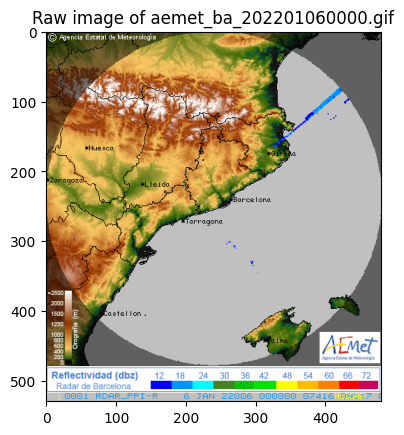

In [18]:
img = pic.filter_based_on_radar_code_and_time(before_dt=datetime(year=2022, month=1, day=7),
                                              after_dt=datetime(year=2022, month=1, day=6),
                                              radar_code='ba').get_image(0)
show_preprocessed_image(img)

In [19]:
import numpy as np
# import diplib as dip
from PIL import Image


def radial_profile(data, center):
    y, x = np.indices(data.shape)
    r = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
    r = r.astype(np.int64)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    return radialprofile


def difference_between_each_radial(radials):
    return np.diff(radials)



In [20]:
import pygame as pg
from pygame.math import Vector2


def points(number, center, radius):
    angle = 360 / number
    point_list = []
    for i in range(number):
        # Create a vector with the length of the radius, rotate it
        # and add it to the center point to get a point on the circumference.
        vec = center + Vector2(radius, 0).rotate(i * angle)
        # pygame.draw.circle needs ints, so we have to convert the vector.
        point_list.append([int(vec.x), int(vec.y)])
    return point_list

In [21]:
import math

# https://gis.stackexchange.com/questions/413062/how-is-it-possible-to-calculate-azimuth-from-a-single-lat-lon-cordinate-with-x
def calculate_bearing(ax, ay, bx, by):
    """Computes the bearing in degrees from the point A(a1,a2) to
    the point B(b1,b2). Note that A and B are given in terms of
    screen coordinates.

    Args:
        ax (int): The x-coordinate of the first point defining a line.
        ay (int): The y-coordinate of the first point defining a line.
        bx (int): The x-coordinate of the second point defining a line.
        by (int): The y-coordinate of the second point defining a line.

    Returns:
        float: bearing in degrees
    """

    TWO_PI = math.pi * 2
    # if (a1 = b1 and a2 = b2) throw an error
    theta = math.atan2(bx - ax, ay - by)
    if (theta < 0.0):
        theta += TWO_PI
    return math.degrees(theta)


def calculate_line_direction(ax, ay, bx, by):
    """Calculates the north relative clockwise orientation of a line.

    Args:
        ax (int): The x-coordinate of the first point defining a line.
        ay (int): The y-coordinate of the first point defining a line.
        bx (int): The x-coordinate of the second point defining a line.
        by (int): The y-coordinate of the second point defining a line.

    Returns:
        float: The direction of the line in degree or nan on failure.
    """
    dx = bx - ax
    dy = by - ay
    m = math.sqrt((dx * dx) + (dy * dy))
    degree = math.degrees(math.atan2(dx / m, dy / m))
    return degree if m > 0 else math.nan


In [22]:
# https://stackoverflow.com/questions/24702868/python3-pillow-get-all-pixels-on-a-line
def interpolate_pixels_along_line(x0, y0, x1, y1):
    """Uses Xiaolin Wu's line algorithm to interpolate all of the pixels along a
    straight line, given two points (x0, y0) and (x1, y1)

    Wikipedia article containing pseudo code that function was based off of:
        http://en.wikipedia.org/wiki/Xiaolin_Wu's_line_algorithm
    """
    pixels = []
    steep = abs(y1 - y0) > abs(x1 - x0)

    # Ensure that the path to be interpolated is shallow and from left to right
    if steep:
        t = x0
        x0 = y0
        y0 = t

        t = x1
        x1 = y1
        y1 = t

    if x0 > x1:
        t = x0
        x0 = x1
        x1 = t

        t = y0
        y0 = y1
        y1 = t

    dx = x1 - x0
    dy = y1 - y0
    gradient = dy / dx  # slope

    # Get the first given coordinate and add it to the return list
    x_end = round(x0)
    y_end = y0 + (gradient * (x_end - x0))
    xpxl0 = x_end
    ypxl0 = round(y_end)
    if steep:
        pixels.extend([(ypxl0, xpxl0), (ypxl0 + 1, xpxl0)])
    else:
        pixels.extend([(xpxl0, ypxl0), (xpxl0, ypxl0 + 1)])

    interpolated_y = y_end + gradient

    # Get the second given coordinate to give the main loop a range
    x_end = round(x1)
    y_end = y1 + (gradient * (x_end - x1))
    xpxl1 = x_end
    ypxl1 = round(y_end)

    # Loop between the first x coordinate and the second x coordinate, interpolating the y coordinates
    for x in range(xpxl0 + 1, xpxl1):
        if steep:
            pixels.extend([(math.floor(interpolated_y), x), (math.floor(interpolated_y) + 1, x)])

        else:
            pixels.extend([(x, math.floor(interpolated_y)), (x, math.floor(interpolated_y) + 1)])

        interpolated_y += gradient

    # Add the second given coordinate to the given list
    if steep:
        pixels.extend([(ypxl1, xpxl1), (ypxl1 + 1, xpxl1)])
    else:
        pixels.extend([(xpxl1, ypxl1), (xpxl1, ypxl1 + 1)])

    return pixels


In [23]:

def get_circum_xy(center, radius, total_points):
    circum_xy = points(total_points, center, radius)
    circum_xy_str = set(["{},{}".format(x, y) for x, y in circum_xy])
    circum_xy_all = [c.split(',') for c in list(circum_xy_str)]
    circum_xy_all = list(map(lambda xy: (int(xy[0]), int(xy[1])), circum_xy_all))
    circum_xy_all = sorted(circum_xy_all)
    return circum_xy_all

In [24]:
def get_coord_and_angles_sorted(circum_xy_all, center):
    bearings = []
    xy_bearings = []
    for xy in circum_xy_all:
        bearings.append(calculate_bearing(center[0], center[1], xy[0], xy[1]))
        xy_bearings.append((xy, bearings[-1]))
    return sorted(xy_bearings, key=lambda x: x[1])


In [25]:
def build_azimuth_histogram(center, coord_angles_sorted, imgarray):
    hist = []
    for coord, _ in coord_angles_sorted:
        if coord[1] >= imgarray.shape[0] or coord[0] >= imgarray.shape[1]:
            continue
        pixel_coords = interpolate_pixels_along_line(center[0], center[1], coord[0], coord[1])
        pixel_vals = np.array([imgarray[xy[1], xy[0]] for xy in pixel_coords])
        count = np.count_nonzero(pixel_vals)  # l0 'loss'
        hist.append(count)
    return hist

In [161]:
SPIKE_THRESHOLD = 20


def find_spike_start_and_end(diff_hist, threshold=SPIKE_THRESHOLD, start_index=0):
    """
    find spike start and end
    a better method is to use find_peaks but I dont have time to test that
    :param diff_hist:
    :param threshold:
    :return:
    """
    if start_index >= len(diff_hist):
        return None, None
    start = None
    end = None
    for i in range(start_index, len(diff_hist)):
        val = diff_hist[i]
        if start is None and val >= threshold:
            start = i
        elif start is not None and val <= -1*threshold:
            end = i
        if start is not None and end is not None:
            return start-1, end+1 # expand boundary to compensate for diff
    return None, None


def find_all_spikes_start_and_end(diff_hist, threshold=SPIKE_THRESHOLD):
    start, end = -1, 0
    start_end_pairs = []
    while start is not None and end is not None:
        start, end = find_spike_start_and_end(diff_hist, threshold, start_index=end)
        if start is not None:
            start_end_pairs.append((start, end))
        # print(start, end)
    return start_end_pairs


def remove_by_azimuth_line(center, circumference_point, imgarray):
    xys = interpolate_pixels_along_line(center[0], center[1], circumference_point[0], circumference_point[1])
    for xy in xys:
        # need to check this
        if xy[1] >= imgarray.shape[0] or xy[0] >= imgarray.shape[1]:
            # print(xy)
            continue
        imgarray[xy[1], xy[0]] = 0
    return imgarray


def remove_by_azimuth_lines(center, coord_angles_sorted, start_end_indices, imgarray):
    for start, end in start_end_indices:
        coords = coord_angles_sorted[start: end+1]
        for coord_angle in coords:
            imgarray = remove_by_azimuth_line(center, coord_angle[0], imgarray)
    return imgarray

In [162]:
def detect_and_remove_rfi_from_image(image: PreprocessedImage, center = (240, 240), radius = 240, total_points = 1800 ) -> np.array:
    # center = (240, 240)
    # radius = 240
    # total_points = 1080  # 1 per azimuth angle
    circum_xy_all = get_circum_xy(center, radius, total_points)
    coord_angles_sorted = get_coord_and_angles_sorted(circum_xy_all, center)
    original_gray_img = image.generate_initial_mask().convert('L')
    imgarray = np.array(original_gray_img).copy()
    hist = build_azimuth_histogram(center, coord_angles_sorted, imgarray)
    diff_hist = np.roll(hist, -1) - hist
    startends = find_all_spikes_start_and_end(diff_hist)
    nimgarray = remove_by_azimuth_lines(center, coord_angles_sorted, startends, imgarray)
    return np.array(original_gray_img), nimgarray, hist, diff_hist, startends

In [178]:
import cv2
def generate_video(img_list,output_name='temp_result.gif',is_PIL=True, channel='RGB'):
    gif=[]
    for image in img_list:
        if is_PIL==False:
            image = Image.fromarray(image.astype('uint8')).convert(channel)
        gif.append(image)
    gif[0].save(output_name, save_all=True,optimize=False, append_images=gif[1:], loop=0)

def save_collection(img_list,output_path):
    i=0
    for image in img_list:
        i=i+1
        save_path = os.path.join(output_path,str(i)+'.jpg')
        cv2.imwrite(save_path,cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

In [163]:
pic2 = pic.filter_based_on_radar_code_and_time(
    radar_code='ba',before_dt=datetime(year=2022, month=5, day=2),after_dt=datetime(year=2022, month=5, day=1))

result_path = os.path.join(*[os.path.dirname(os.path.realpath(os.getcwd())), 'result_cloudy'])
original_masks = []
rfi_removed_masks = []
hists = []
diff_hists = []
startends = []
i = 0
for pi in pic2.preprocessed_images:
    i+=1
    original_gray, rfi_removed_array, hist, diff_hist, startends  = detect_and_remove_rfi_from_image(pi)
    original_masks.append(original_gray)
    rfi_removed_masks.append(rfi_removed_array)
    hists.append(hist)
    diff_hists.append(diff_hist)
    startends.append(startends)


    # fig, axes = plt.subplots(5, figsize=(5, 25))
    # axes[0].imshow(pi.load_image())
    # axes[1].imshow(original_gray)
    # axes[2].imshow(rfi_removed_array)
    # axes[3].plot([i for i in range(len(hist))], hist)
    # axes[4].plot([i for i in range(len(diff_hist))], diff_hist)
    # axes[1].set_title('Original Image in Gray')
    # axes[2].set_title('Cleaned Image in Gray')
    # axes[3].set_title('Histogram of azimuth reflectivity l0 sum')
    # axes[3].set_ylabel('Reflectivity 0 sum')
    # axes[3].set_xlabel('Azimuth Index')
    # axes[4].set_title('Histogram of diff azimuth reflective l0 sum')
    # axes[4].set_ylabel('Diff Reflectivity 0 sum')
    # axes[4].set_xlabel('Azimuth Index')
    # fname = os.path.join(*[result_path, os.path.basename(pi.file_path)])[:-4] + '.jpg'
    # fig.savefig(fname)
    # plt.close(fig)
    # break


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143


In [184]:
pic2.preprocessed_images[87].load_image().show()

In [185]:
# np.hstack((original_masks, rfi_removed_masks))
generate_video(original_masks, output_name='../result_cloudy/original.gif', is_PIL=False, channel='RGB')
generate_video(rfi_removed_masks, output_name='../result_cloudy/rfi_removed_mask.gif', is_PIL=False, channel='RGB')


In [175]:
diff_hists